In [1]:
import numpy as np
import netCDF4 as nc
import sys,os

import pandas as pd
import data_info
#import iris
#import iris.plot as iplt
#import iris.quickplot as qplt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(20,16)
%matplotlib inline


In [2]:
GtC_to_ppm=0.471
ppm_to_kgC = 1e12/GtC_to_ppm

In [184]:
DATA_DIR = '/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/'
PLOT_DIR = '/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/plots/'
os.system('mkdir '+PLOT_DIR)


0

In [163]:
#GCMs = ['CEN_CSIRO-QCCCE_MOD_CSIRO-Mk3-6-0','CEN_MOHC_MOD_HadGEM2-ES','CEN_NOAA-GFDL_MOD_GFDL-ESM2G']
GCMs  = ['CEN_BCC_MOD_bcc-csm1-1-m','CEN_BCC_MOD_bcc-csm1-1','CEN_CCCma_MOD_CanESM2','CEN_CMCC_MOD_CMCC-CMS',
         'CEN_CSIRO-BOM_MOD_ACCESS1-0','CEN_CSIRO-BOM_MOD_ACCESS1-3','CEN_CNRM-CERFACS_MOD_CNRM-CM5',
         'CEN_CSIRO-QCCCE_MOD_CSIRO-Mk3-6-0','CEN_INM_MOD_inmcm4','CEN_IPSL_MOD_IPSL-CM5B-LR',
         'CEN_IPSL_MOD_IPSL-CM5A-MR','CEN_MIROC_MOD_MIROC-ESM-CHEM','CEN_MIROC_MOD_MIROC-ESM',
         'CEN_MIROC_MOD_MIROC5','CEN_MOHC_MOD_HadGEM2-CC']
nGCMs = len(GCMs)
SCENARIOs = ['1p5equi','2equi']
#SCENARIOs = ['2equi']
SCENARIO_names=['1.5 K','2 K']
#SCENARIO_names=['2 K']
nSCENARIOs=len(SCENARIOs)
runid='EQUI'

pre_industrial_file='/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/PRE_INDUSTRIAL/vn4.8_imogen.spinup_710.dump.1850_zeroDtemp_zeroWP.nc'

In [164]:
ANCILS_DIR='/prj/CLIFFTOP/COMMON_DATA/ANCILS/'
#GRID_file= ANCILS_DIR+'grid_info.nc'
#grinf=nc.Dataset(GRID_file,'r')
#lats_2d = grinf.variables['latitude'][:]
#lons_2d = grinf.variables['longitude'][:]
#Area_2d = grinf.variables['Area'][:]
#land_index = grinf.variables['land_index'][:]
#grinf.close()

AREA_file=ANCILS_DIR+'Area_in_iris_format.nc'
Ainf=nc.Dataset(AREA_file,'r')
AREA_1D = Ainf.variables['area'][:]
Ainf.close()

# soil layer thicknesses
dz_soil= np.array([0.05,0.08408964,0.11397535,0.14142136,0.16718508,0.19168293,
                   0.21517585,0.23784142,0.25980762,0.28117066,0.30200527,
                   0.32237098,0.34231625,0.36188121])
dweight_soil = dz_soil/np.sum(dz_soil)
print(np.sum(dweight_soil))
print(dweight_soil)

tiles= data_info.TILE_short_names


1.0
[ 0.01628175  0.02738252  0.03711436  0.04605173  0.0544413   0.06241866
  0.07006877  0.07744947  0.08460244  0.09155899  0.09834347  0.10497525
  0.11147013  0.11784116]


In [210]:
dump_vars=['co2_mmr','cv','cs','frac','dtemp_o']
stock_vars = ['CV','CS','AtmCO2_ppm','AtmCO2_kg','frac']#,'OceanCO2']

DATA_DICT={}

for scenario in SCENARIOs:
    print('Scenario: ',scenario)
    DATA_DICT[scenario]={ var:[] for var in stock_vars  }
    for gcm in GCMs:
        print('GCM: ',gcm)
        DUMP_FILE=DATA_DIR+gcm+'/'+runid+'_'+gcm+'_'+scenario+'.dump.21000101.0.nc'
        print(DUMP_FILE)
        DINF = nc.Dataset(DUMP_FILE,'r')
        
        #Ann_File=DATA_DIR+runid+'_'+gcm+'_'+scenario+'.Annual_carbon.nc'
        #print(Ann_File)
        #Ainf=nc.Dataset(Ann_File,'r')
        
        # Vegetation Carbon is just on land points:
        CV = np.sum(DINF.variables['cv'][:]*AREA_1D)
        #CV = np.sum(Ainf.variables['cv'][:].squeeze()*AREA_1D)
        print('CV = ',CV)
        DATA_DICT[scenario]['CV'].append(CV)
        
        # Soil Carbon needs to be summed over pools and layers
        # extract and sum over pools, 1st dimension
        CS = np.sum(DINF.variables['cs'][:],axis=0)
        # sum over layers
        #CS = np.sum( CS.transpose(1,0)*dz_soil,axis=1 )
        CS = np.sum( CS.transpose(1,0),axis=1 )
        # finally sum over land points:
        CS = np.sum( CS*AREA_1D )
        #CS = np.sum(Ainf.variables['cs_gb'][:].squeeze()*AREA_1D)
        print('CS = ', CS)
        DATA_DICT[scenario]['CS'].append(CS)
        
        #Atmospheric CO2 
        AtmCO2_ppm = DINF.variables['co2_ppmv'][0]
        AtmCO2_kg = AtmCO2_ppm*ppm_to_kgC
        print('AtmCO2 = ',AtmCO2_kg)
        DATA_DICT[scenario]['AtmCO2_kg'].append(AtmCO2_kg)
        DATA_DICT[scenario]['AtmCO2_ppm'].append(AtmCO2_ppm)
        
        # Ocean CO2 from dtemp_o
        DTEMP_O = DINF.variables['dtemp_o'][:]
        OCEAN_CO2 = AtmCO2_ppm * np.exp(0.0423*DTEMP_O[0]) * ppm_to_kgC
        print('OCEAN_CO2 = ',OCEAN_CO2)
        #DATA_DICT[scenario]['OceanCO2'].append(OCEAN_CO2)
        
        
        FRAC = np.sum(DINF.variables['frac'][:]*AREA_1D.squeeze()*1e-10,axis=1)  # m^2 to Mha
        DATA_DICT[scenario]['frac'].append(FRAC)
        print(FRAC)
        
        
        DINF.close()
    print('=====================================================')
            
        


Scenario:  1p5equi
GCM:  CEN_BCC_MOD_bcc-csm1-1-m
/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/CEN_BCC_MOD_bcc-csm1-1-m/EQUI_CEN_BCC_MOD_bcc-csm1-1-m_1p5equi.dump.21000101.0.nc
CV =  4.56607e+14
CS =  2.14623e+15
AtmCO2 =  8.30528178286e+14
OCEAN_CO2 =  8.77922720251e+14
[  343.67996216  1155.25219727    29.36953545   163.56382751  1409.32861328
   533.64550781   813.96020508   957.04724121   507.96569824   713.86230469
   952.20153809   356.69613647   522.57531738    19.69851303   219.19793701
  4378.64160156   140.09387207]
GCM:  CEN_BCC_MOD_bcc-csm1-1
/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/CEN_BCC_MOD_bcc-csm1-1/EQUI_CEN_BCC_MOD_bcc-csm1-1_1p5equi.dump.21000101.0.nc
CV =  4.58858e+14
CS =  2.14376e+15
AtmCO2 =  8.30399369485e+14
OCEAN_CO2 =  8.76628258765e+14
[  347.14855957  1157.89025879    29.04626465   166.27787781  1411.10314941
   533.26660156   807.57110596   954.40985107   502.51013184   718.91271973
   924.56347656   348.0692749    521.70404053    19.69851303   219.1979

In [211]:

PreI_DICT={}
print('GCM: ',gcm)
DUMP_FILE=pre_industrial_file
print(DUMP_FILE)
DINF = nc.Dataset(DUMP_FILE,'r')
        
CV = np.sum(DINF.variables['cv']*AREA_1D)
print('CV = ',CV)
PreI_DICT['CV']=CV


CS = np.sum(DINF.variables['cs'][:],axis=0)
CS = np.sum( CS.transpose(1,0),axis=1 )
CS = np.sum( CS*AREA_1D )
print('CS = ', CS)
PreI_DICT['CS']=CS
        
#Atmospheric CO2 
AtmCO2_ppm = DINF.variables['co2_ppmv'][0]
AtmCO2_kg = AtmCO2_ppm*ppm_to_kgC
print('AtmCO2 = ',AtmCO2_kg)
PreI_DICT['AtmCO2_kg']=AtmCO2_kg
PreI_DICT['AtmCO2_ppm']=AtmCO2_ppm
        
# Ocean CO2 from dtemp_o
DTEMP_O = DINF.variables['dtemp_o'][:]
OCEAN_CO2 = AtmCO2_ppm * np.exp(0.0423*DTEMP_O[0]) * ppm_to_kgC
print('OCEAN_CO2 = ',OCEAN_CO2)
#PreI_DICT['OceanCO2']=OCEAN_CO2


FRAC = np.sum(DINF.variables['frac'][:]*AREA_1D.squeeze()*1e-10,axis=-1)#.squeeze()  #*1e-10 (m2 to Mha)
print(FRAC.shape)
PreI_DICT['frac']=FRAC
print(FRAC)
        
DINF.close()

GCM:  CEN_MOHC_MOD_HadGEM2-CC
/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/PRE_INDUSTRIAL/vn4.8_imogen.spinup_710.dump.1850_zeroDtemp_zeroWP.nc
CV =  6.91488e+14
CS =  2.08512e+15
AtmCO2 =  6.05174977815e+14
OCEAN_CO2 =  6.05174977815e+14
(17,)
[  828.55847168  2241.08251953    90.12862396   101.69768524  1730.18212891
   823.08227539   337.67059326   106.55014038   764.42907715   190.53207397
   197.43884277   173.02072144   610.69940186    19.69851303   219.19793701
  4642.71679688   140.09387207]


In [212]:
#DATA_DICT


[391.17877, 391.1181, 358.22556, 396.8295, 385.43686, 391.76871, 414.23785, 402.61884, 464.49915, 400.7742, 358.77072, 360.05643, 352.70239, 415.74698, 385.55725]
[447.09122, 447.89731, 399.18158, 456.88983, 440.17587, 448.55927, 482.67633, 465.36533, 559.20819, 462.88885, 399.7525, 402.02271, 390.95993, 485.55435, 440.44202]


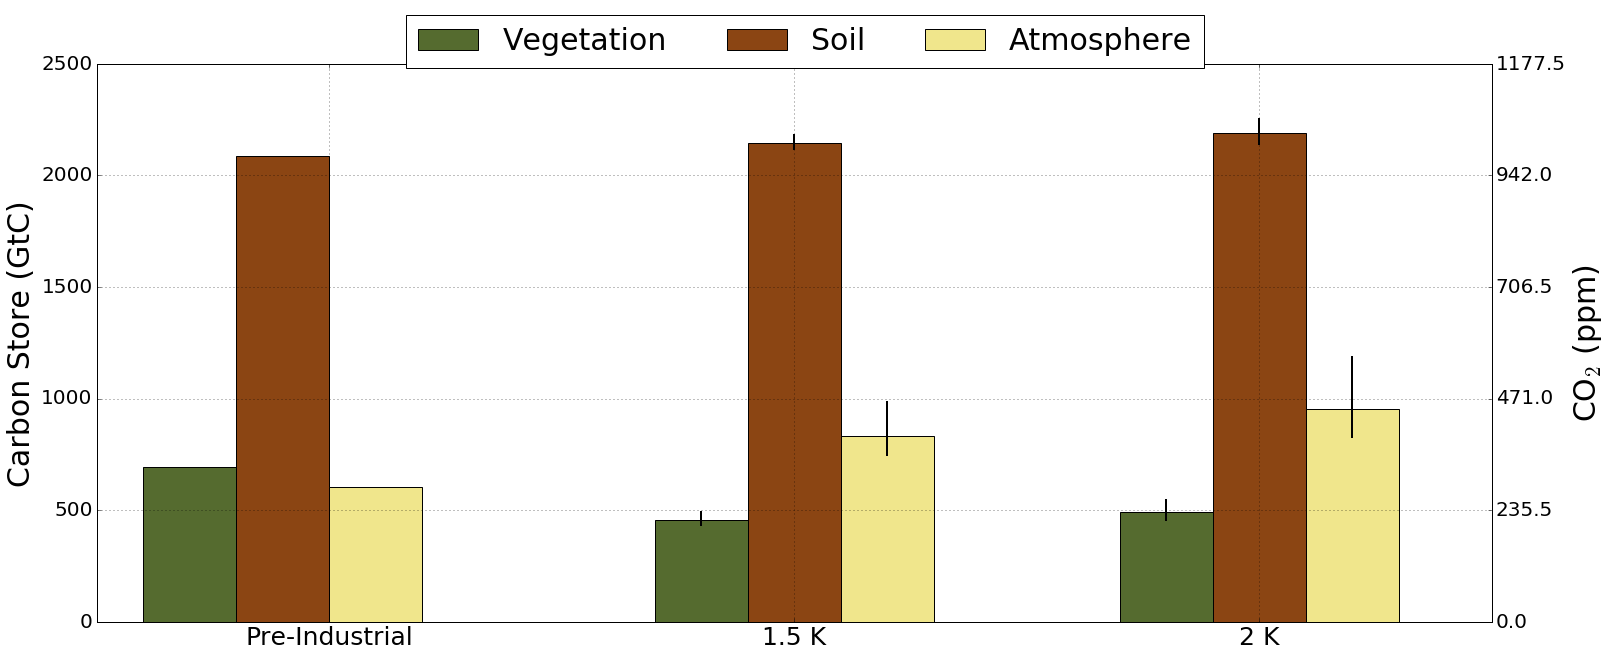

In [213]:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=[25,10])

bar_width=0.2
ax.set_xlim([0,nSCENARIOs+1.])

#Plot Pre-Industrial First
CV = np.array(PreI_DICT['CV'])*1e-12
CS = np.array(PreI_DICT['CS'])*1e-12
Land_C = CV+CS
AtmCO2 = np.array(PreI_DICT['AtmCO2_kg'])*1e-12
#OceanCO2 = np.array(DATA_DICT[scenario]['OceanCO2'])*1e-12
# Land position, iSCENARIO-0.2
iscenario=0
xpos = iscenario+0.5-0.4
cv_bar=ax.bar(xpos,np.mean(CV),color='darkolivegreen',width=bar_width)
#cs_bar=ax.bar(xpos,np.mean(CS),bottom=np.mean(CV),color='saddlebrown',width=bar_width)
ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(CV),np.max(CV)],c='k',lw=2)
xpos = iscenario+0.5-0.2
cs_bar=ax.bar(xpos,np.mean(CS),color='saddlebrown',width=bar_width)
ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(CS),np.max(CS)],c='k',lw=2)

xpos = iscenario+0.5-0.
atm_bar=ax.bar(xpos,np.mean(AtmCO2),color='khaki',width=bar_width)
ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(AtmCO2),np.max(AtmCO2)],c='k',lw=2)

#xpos = iscenario+0.5+0.2
#ocean_bar=ax.bar(xpos,np.mean(OceanCO2),color='turquoise',width=bar_width)
#ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(OceanCO2),np.max(OceanCO2)],c='k',lw=2)


for iscenario in range(nSCENARIOs):
    scenario=SCENARIOs[iscenario]
    CV = np.array(DATA_DICT[scenario]['CV'])*1e-12
    CS = np.array(DATA_DICT[scenario]['CS'])*1e-12
    Land_C = CV+CS
    AtmCO2 = np.array(DATA_DICT[scenario]['AtmCO2_kg'])*1e-12
    #OceanCO2 = np.array(DATA_DICT[scenario]['OceanCO2'])*1e-12
    print(DATA_DICT[scenario]['AtmCO2_ppm'])
    
    # Land position, iSCENARIO-0.2
    xpos = iscenario+1.5-0.3
    ax.bar(xpos,np.mean(CV),color='darkolivegreen',width=bar_width)
    #cs_bar=ax.bar(xpos,np.mean(CS),bottom=np.mean(CV),color='saddlebrown',width=bar_width)
    ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(CV),np.max(CV)],c='k',lw=2)
    xpos = iscenario+1.5-0.1
    ax.bar(xpos,np.mean(CS),color='saddlebrown',width=bar_width)
    ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(CS),np.max(CS)],c='k',lw=2)
    
    xpos = iscenario+1.5+0.1
    ax.bar(xpos,np.mean(AtmCO2),color='khaki',width=bar_width)
    ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(AtmCO2),np.max(AtmCO2)],c='k',lw=2)
    
    #xpos = iscenario+0.5+0.2
    #ocean_bar=ax.bar(xpos,np.mean(OceanCO2),color='turquoise',width=bar_width)
    #ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(OceanCO2),np.max(OceanCO2)],c='k',lw=2)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0.5,nSCENARIOs+1,1.))
ax.set_xticklabels(['Pre-Industrial']+SCENARIO_names,fontsize=25)
ax.set_ylabel('Carbon Store (GtC)',fontsize=30)
ax.tick_params(axis='y',labelsize=20)
ax.grid(True)

# right hand labels in ppm
ax2=ax.twinx()
ax2.set_ylabel('CO$_2$ (ppm)',fontsize=30)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks=ax.get_yticks()
ax2.set_yticklabels([label*GtC_to_ppm for label in ax.get_yticks()])
ax2.tick_params(axis='y',labelsize=20)


#fig.legend([cv_bar,cs_bar,atm_bar,ocean_bar],['Vegetation','Soil','Atmosphere','Ocean'],\
#          loc='upper center',ncol=4,fontsize=30)
fig.legend([cv_bar,cs_bar,atm_bar],['Vegetation','Soil','Atmosphere'],\
          loc='upper center',ncol=4,fontsize=30)
fig.savefig(PLOT_DIR+'Equilibrium_CarbonStores.png')

[391.17877, 391.1181, 358.22556, 396.8295, 385.43686, 391.76871, 414.23785, 402.61884, 464.49915, 400.7742, 358.77072, 360.05643, 352.70239, 415.74698, 385.55725]
[447.09122, 447.89731, 399.18158, 456.88983, 440.17587, 448.55927, 482.67633, 465.36533, 559.20819, 462.88885, 399.7525, 402.02271, 390.95993, 485.55435, 440.44202]


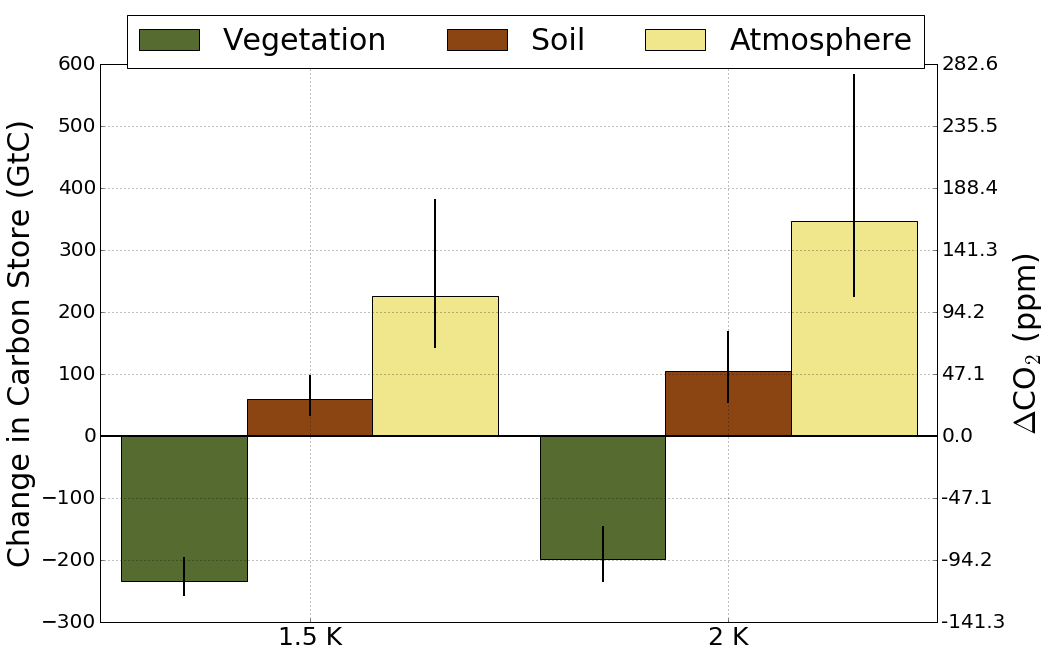

In [214]:
# plot Delta Cstores
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=[15,10])

bar_width=0.3
ax.set_xlim([0,nSCENARIOs])

for iscenario in range(nSCENARIOs):
    scenario=SCENARIOs[iscenario]
    CV = np.array(DATA_DICT[scenario]['CV']-PreI_DICT['CV'])*1e-12
    CS = np.array(DATA_DICT[scenario]['CS']-PreI_DICT['CS'])*1e-12
    Land_C = CV+CS
    AtmCO2 = np.array(DATA_DICT[scenario]['AtmCO2_kg']-PreI_DICT['AtmCO2_kg'])*1e-12
    #OceanCO2 = np.array(DATA_DICT[scenario]['OceanCO2'])*1e-12
    print(DATA_DICT[scenario]['AtmCO2_ppm'])
    
    # Land position, iSCENARIO-0.2
    xpos = iscenario+0.5-0.45
    ax.bar(xpos,np.mean(CV),color='darkolivegreen',width=bar_width)
    #cs_bar=ax.bar(xpos,np.mean(CS),bottom=np.mean(CV),color='saddlebrown',width=bar_width)
    ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(CV),np.max(CV)],c='k',lw=2)
    xpos = iscenario+0.5-0.15
    ax.bar(xpos,np.mean(CS),color='saddlebrown',width=bar_width)
    ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(CS),np.max(CS)],c='k',lw=2)
    
    xpos = iscenario+0.5+0.15
    ax.bar(xpos,np.mean(AtmCO2),color='khaki',width=bar_width)
    ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(AtmCO2),np.max(AtmCO2)],c='k',lw=2)
    
    #xpos = iscenario+0.5+0.2
    #ocean_bar=ax.bar(xpos,np.mean(OceanCO2),color='turquoise',width=bar_width)
    #ax.plot([xpos+bar_width/2,xpos+bar_width/2],[np.min(OceanCO2),np.max(OceanCO2)],c='k',lw=2)
    
ax.plot(ax.get_xlim(),[0,0],c='k',lw=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.tick_params(labelright=True)
ax.set_xticks(np.arange(0.5,nSCENARIOs,1.))
ax.set_xticklabels(SCENARIO_names,fontsize=25)
ax.set_ylabel('Change in Carbon Store (GtC)',fontsize=30)
ax.tick_params(axis='y',labelsize=20)
ax.grid(True)

# right hand labels in ppm
ax2=ax.twinx()
ax2.set_ylabel('$\Delta$CO$_2$ (ppm)',fontsize=30)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks=ax.get_yticks()
ax2.set_yticklabels([label*GtC_to_ppm for label in ax.get_yticks()])
ax2.tick_params(axis='y',labelsize=20)


#fig.legend([cv_bar,cs_bar,atm_bar,ocean_bar],['Vegetation','Soil','Atmosphere','Ocean'],\
#          loc='upper center',ncol=4,fontsize=30)
fig.legend([cv_bar,cs_bar,atm_bar],['Vegetation','Soil','Atmosphere'],\
          loc=9,ncol=4,fontsize=30)  #'upper center'

fig.savefig(PLOT_DIR+'Equilibrium_DeltaCarbonStores.png')

In [215]:
labels=ax.get_yticks()
label=labels[0]
print(label)


-300.0


In [216]:
DATA_DICT[scenario]['frac']
Tile_names=data_info.TILE_short_names()
Tile_colours = data_info.TILE_colours()
print(Tile_names)
nTiles=len(Tile_names)

Tile_Dict = { scenario:{tile:[] for tile in Tile_names} for scenario in SCENARIOs }

for scenario in SCENARIOs:
    for iTile in range(nTiles):
        for i_gcm in range(nGCMs):
            Tile_Dict[scenario][Tile_names[iTile]].append(DATA_DICT[scenario]['frac'][i_gcm][iTile])
        Tile_Dict[scenario][Tile_names[iTile]] = np.array(Tile_Dict[scenario][Tile_names[iTile]])

#
    
#print(Tile_Dict)

['Dec-BL', 'Trop-BL', 'Temp-BL', 'Dec-NL', 'Ever-NL', 'C3-grass', 'C3-crop', 'C3-past', 'C4-grass', 'C4-crop', 'C4-past', 'Dec-shrub', 'Ever-shrub', 'Urban', 'Lake', 'Soil', 'Ice']


In [217]:
PreI_DICT['frac']

array([  828.55847168,  2241.08251953,    90.12862396,   101.69768524,
        1730.18212891,   823.08227539,   337.67059326,   106.55014038,
         764.42907715,   190.53207397,   197.43884277,   173.02072144,
         610.69940186,    19.69851303,   219.19793701,  4642.71679688,
         140.09387207], dtype=float32)

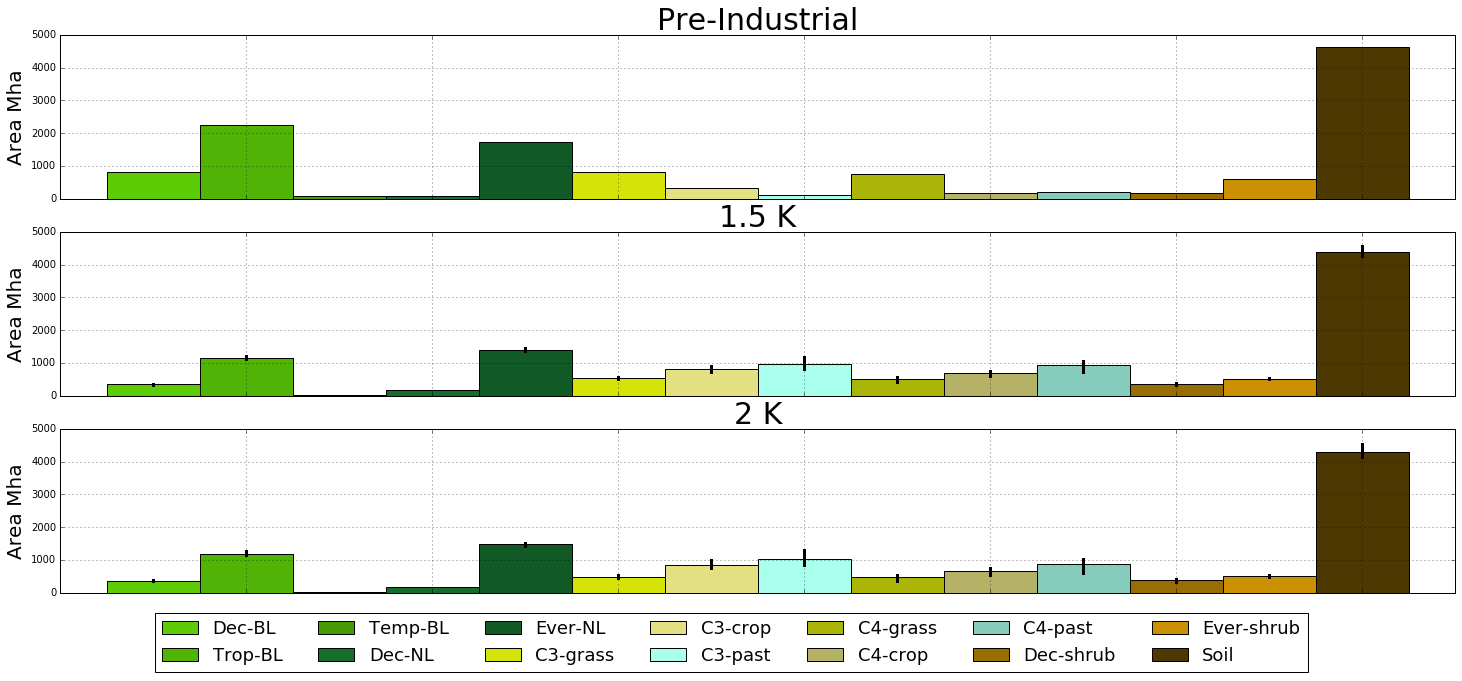

In [218]:
fig,axes=plt.subplots(ncols=1,nrows=1+nSCENARIOs,figsize=[25,10])

plotTiles_locs = list(range(13))+[15]
nPLOTtiles=len(plotTiles_locs)

bar_width=1.
#OceanCO2 = np.array(DATA_DICT[scenario]['OceanCO2'])*1e-12
# Land position, iSCENARIO-0.2
ax=axes[0]
for iTilea in range(nPLOTtiles):  # Tiles):
    xpos=iTilea+0.5
    iTile=plotTiles_locs[iTilea]
    ax.bar(xpos,PreI_DICT['frac'][iTile],color=Tile_colours[iTile],width=bar_width,label=Tile_names[iTile])
ax.set_ylabel('Area Mha',fontsize=20)
ax.set_xticklabels(['' for i in range(nPLOTtiles)])
ax.set_xlim([0,nPLOTtiles+1])
ax.set_title('Pre-Industrial',fontsize=30)
ax.grid(True)

for iscenario in range(nSCENARIOs):
    ax=axes[iscenario+1]
    scenario=SCENARIOs[iscenario]
    for iTilea in range(nPLOTtiles):  # Tiles):
        xpos=iTilea+0.5
        iTile=plotTiles_locs[iTilea]
        tile=Tile_names[iTile]
        ax.bar(xpos,np.mean(Tile_Dict[scenario][tile]),color=Tile_colours[iTile],width=bar_width)
        ax.plot([xpos+0.5,xpos+0.5],[np.min(Tile_Dict[scenario][tile]),np.max(Tile_Dict[scenario][tile])],lw=3,c='k')
    ax.set_ylabel('Area Mha',fontsize=20)
    #ax.set_xticklabels(['' for i in range(nTiles)])
    ax.set_xticklabels(['' for i in range(nPLOTtiles)])
    ax.set_xlim([0,nPLOTtiles+1])
    ax.set_title(SCENARIO_names[iscenario],fontsize=30)
    ax.grid(True)

handles,labels = axes[0].get_legend_handles_labels()
fig.legend(handles,labels,ncol=int(np.ceil(nPLOTtiles/2.)),loc=8,fontsize=18)

fig.savefig(PLOT_DIR+'Equilibrium_CoverFractions.png')

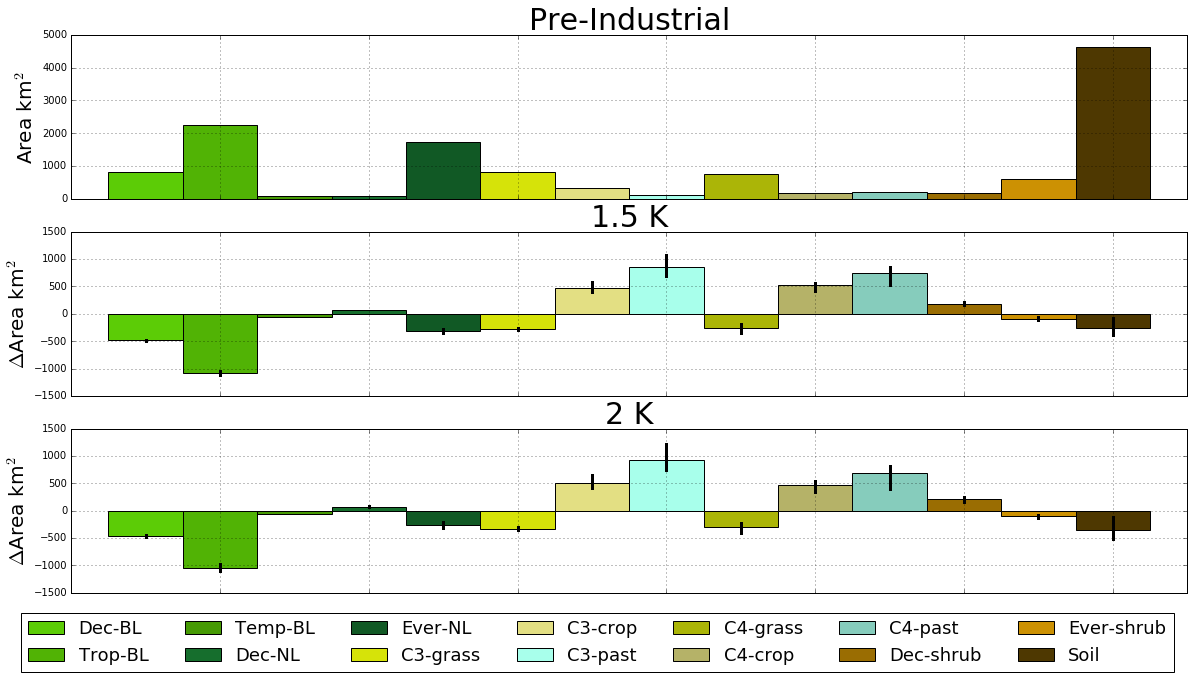

In [219]:
fig,axes=plt.subplots(ncols=1,nrows=1+nSCENARIOs,figsize=[20,10])

plotTiles_locs = list(range(13))+[15]
nPLOTtiles=len(plotTiles_locs)

bar_width=1.
#OceanCO2 = np.array(DATA_DICT[scenario]['OceanCO2'])*1e-12
# Land position, iSCENARIO-0.2
ax=axes[0]
for iTilea in range(nPLOTtiles):  # Tiles):
    xpos=iTilea+0.5
    iTile=plotTiles_locs[iTilea]
    ax.bar(xpos,PreI_DICT['frac'][iTile],color=Tile_colours[iTile],width=bar_width,label=Tile_names[iTile])
ax.set_ylabel('Area km$^2$',fontsize=20)
ax.set_xticklabels(['' for i in range(nPLOTtiles)])
ax.set_xlim([0,nPLOTtiles+1])
ax.set_title('Pre-Industrial',fontsize=30)
ax.grid(True)

for iscenario in range(nSCENARIOs):
    ax=axes[iscenario+1]
    scenario=SCENARIOs[iscenario]
    for iTilea in range(nPLOTtiles):  # Tiles):
        xpos=iTilea+0.5
        iTile=plotTiles_locs[iTilea]
        tile=Tile_names[iTile]
        DIFF_DATA=Tile_Dict[scenario][tile]-PreI_DICT['frac'][iTile]
        ax.bar(xpos,np.mean(DIFF_DATA),color=Tile_colours[iTile],width=bar_width)
        ax.plot([xpos+0.5,xpos+0.5],[np.min(DIFF_DATA),np.max(DIFF_DATA)],lw=3,c='k')
               
    ax.set_ylabel('$\Delta$Area km$^2$',fontsize=20)
    #ax.set_xticklabels(['' for i in range(nTiles)])
    ax.set_xticklabels(['' for i in range(nPLOTtiles)])
    ax.set_xlim([0,nPLOTtiles+1])
    ax.set_title(SCENARIO_names[iscenario],fontsize=30)
    ax.grid(True)

handles,labels = axes[0].get_legend_handles_labels()
fig.legend(handles,labels,ncol=int(np.ceil(nPLOTtiles/2.)),loc=8,fontsize=18)
    
fig.savefig(PLOT_DIR+'Equilibrium_DeltaCoverFractions.png')

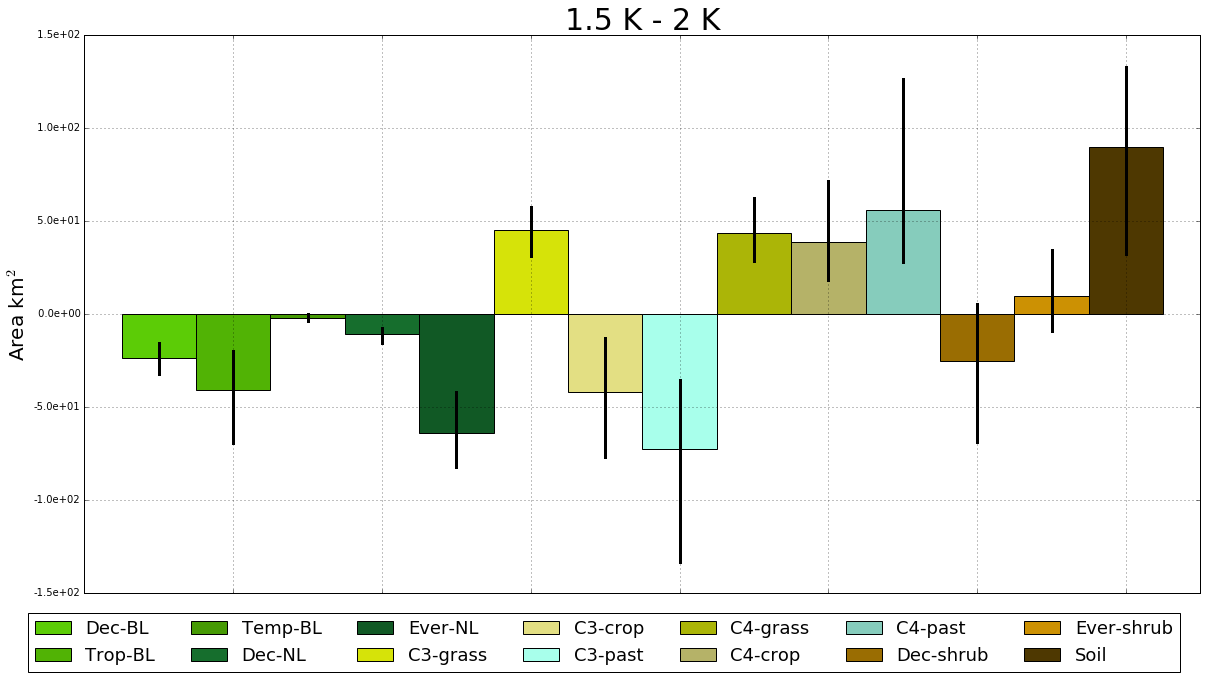

In [220]:
fig,axes=plt.subplots(ncols=1,nrows=1,figsize=[20,10])

plotTiles_locs = list(range(13))+[15]
nPLOTtiles=len(plotTiles_locs)

bar_width=1.
#OceanCO2 = np.array(DATA_DICT[scenario]['OceanCO2'])*1e-12
# Land position, iSCENARIO-0.2
ax=axes
for iTilea in range(nPLOTtiles):  # Tiles):
    xpos=iTilea+0.5
    iTile=plotTiles_locs[iTilea]
    tile=Tile_names[iTile]
    DIFF_DATA=Tile_Dict['1p5equi'][tile]-Tile_Dict['2equi'][tile]
    ax.bar(xpos,np.mean(DIFF_DATA),color=Tile_colours[iTile],width=bar_width,label=Tile_names[iTile])
    ax.plot([xpos+0.5,xpos+0.5],[np.min(DIFF_DATA),np.max(DIFF_DATA)],lw=3,c='k')
ax.set_ylabel('Area km$^2$',fontsize=20)
ax.set_xticklabels(['' for i in range(nPLOTtiles)])
ax.set_xlim([0,nPLOTtiles+1])
ax.set_yticklabels([str('%8.1e'%label) for label in ax.get_yticks()])
ax.set_title('1.5 K - 2 K',fontsize=30)
ax.grid(True)

handles,labels = axes.get_legend_handles_labels()
fig.legend(handles,labels,ncol=int(np.ceil(nPLOTtiles/2.)),loc=8,fontsize=18)


In [7]:
dump_vars=['co2_mmr','cv','cs','frac','dtemp_o']
stock_vars = ['CV','CS','AtmCO2_ppm','AtmCO2_kg','OceanCO2']

DATA_DICT={}

for scenario in SCENARIOs:
    print('Scenario: ',scenario)
    DATA_DICT[scenario]={ var:[] for var in stock_vars  }
    for gcm in GCMs:
        print('GCM: ',gcm)
        DUMP_FILE=DATA_DIR+runid+'_'+gcm+'_'+scenario+'.dump.nc'
        print(DUMP_FILE)
        DINF = nc.Dataset(DUMP_FILE,'r')
        
        Ann_File=DATA_DIR+runid+'_'+gcm+'_'+scenario+'.Annual_carbon.nc'
        print(Ann_File)
        Ainf=nc.Dataset(Ann_File,'r')
        
        # Vegetation Carbon is just on land points:
        #CV = np.sum(DINF.variables['cv']*AREA_1D)
        CV = np.sum(Ainf.variables['cv'][:].squeeze()*AREA_1D)
        print('CV = ',CV)
        DATA_DICT[scenario]['CV'].append(CV)
        
        # Soil Carbon needs to be summed over pools and layers
        # extract and sum over pools, 1st dimension
        #CS = np.sum(DINF.variables['cs'][:],axis=0)
        ## sum over layers
        #CS = np.sum( CS.transpose(1,0)*dz_soil,axis=1 )
        ## finally sum over land points:
        #CS = np.sum( CS*AREA_1D )
        CS = np.sum(Ainf.variables['cs_gb'][:].squeeze()*AREA_1D)
        print('CS = ', CS)
        DATA_DICT[scenario]['CS'].append(CS)
        
        #Atmospheric CO2 
        AtmCO2_ppm = DINF.variables['co2_ppmv'][0]
        AtmCO2_kg = AtmCO2_ppm*ppm_to_kgC
        print('AtmCO2 = ',AtmCO2_kg)
        DATA_DICT[scenario]['AtmCO2_kg'].append(AtmCO2_kg)
        DATA_DICT[scenario]['AtmCO2_ppm'].append(AtmCO2_ppm)
        
        # Ocean CO2 from dtemp_o
        DTEMP_O = DINF.variables['dtemp_o'][:]
        OCEAN_CO2 = AtmCO2_ppm * np.exp(0.0423*DTEMP_O[0]) * ppm_to_kgC
        print('OCEAN_CO2 = ',OCEAN_CO2)
        DATA_DICT[scenario]['OceanCO2'].append(OCEAN_CO2)
        
        DINF.close()
    print('=====================================================')
            
        


Scenario:  0equi
GCM:  CEN_CSIRO-QCCCE_MOD_CSIRO-Mk3-6-0
/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/EQUI_CEN_CSIRO-QCCCE_MOD_CSIRO-Mk3-6-0_0equi.Annual_carbon.nc
CV =  7.01581e+14
CS =  2.03758e+15
AtmCO2 =  6.05174977815e+14
OCEAN_CO2 =  6.05174977815e+14
GCM:  CEN_MOHC_MOD_HadGEM2-ES
/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/EQUI_CEN_MOHC_MOD_HadGEM2-ES_0equi.Annual_carbon.nc
CV =  7.01586e+14
CS =  2.03759e+15
AtmCO2 =  6.05174977815e+14
OCEAN_CO2 =  6.05174977815e+14
GCM:  CEN_NOAA-GFDL_MOD_GFDL-ESM2G
/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/EQUI_CEN_NOAA-GFDL_MOD_GFDL-ESM2G_0equi.Annual_carbon.nc
CV =  7.01584e+14
CS =  2.03757e+15
AtmCO2 =  6.05174977815e+14
OCEAN_CO2 =  6.05174977815e+14
Scenario:  1p5equi
GCM:  CEN_CSIRO-QCCCE_MOD_CSIRO-Mk3-6-0
/prj/CLIFFTOP/ECP_output/EQUILIBRIUM_OUTPUT/EQUI_CEN_CSIRO-QCCCE_MOD_CSIRO-Mk3-6-0_1p5equi.Annual_carbon.nc
CV =  4.54621e+14
CS =  2.17206e+15
AtmCO2 =  8.5121695808e+14
OCEAN_CO2 =  8.9947953165e+14
GCM:  CEN_MOHC_MOD_HadGEM2-ES
